In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os


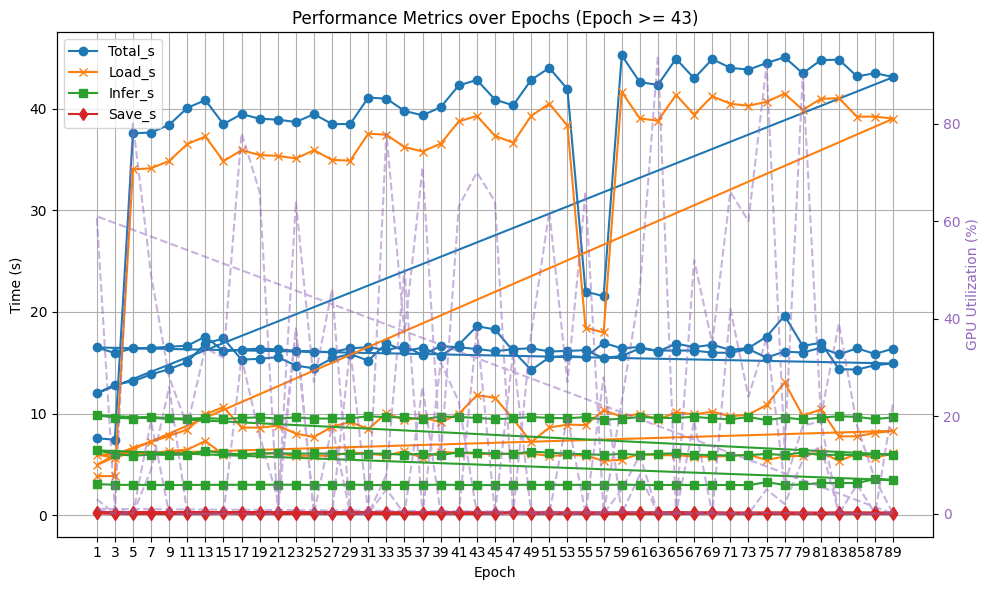

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the data
file_path = '/projectnb/eb-general/wade/sfno/inference_runs/sandbox/Experiment2/2022_12_27/2_performance_log_2022-12-27.csv'
df = pd.read_csv(file_path)

# 2. Clean the data
df['GPU_Util'] = df['GPU_Util'].str.rstrip('%').astype(float)


# split up the data lines where the first word is Initialization
df = df[~df['Epoch'].astype(str).str.startswith('Initialization')]

# 4. Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Time metrics on the left y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Time (s)')
ax1.plot(df['Epoch'], df['Total_s'], label='Total_s', marker='o')
ax1.plot(df['Epoch'], df['Load_s'], label='Load_s', marker='x')
ax1.plot(df['Epoch'], df['Infer_s'], label='Infer_s', marker='s')
ax1.plot(df['Epoch'], df['Save_s'], label='Save_s', marker='d')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot GPU Utilization on the right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('GPU Utilization (%)', color='tab:purple')
ax2.plot(df['Epoch'], df['GPU_Util'], color='tab:purple', linestyle='--', label='GPU_Util', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='tab:purple')

plt.title('Performance Metrics over Epochs')
plt.tight_layout()
plt.savefig('performance_metrics_exp2.png')
# plt.show()

let's highlight which task number each epoch is in

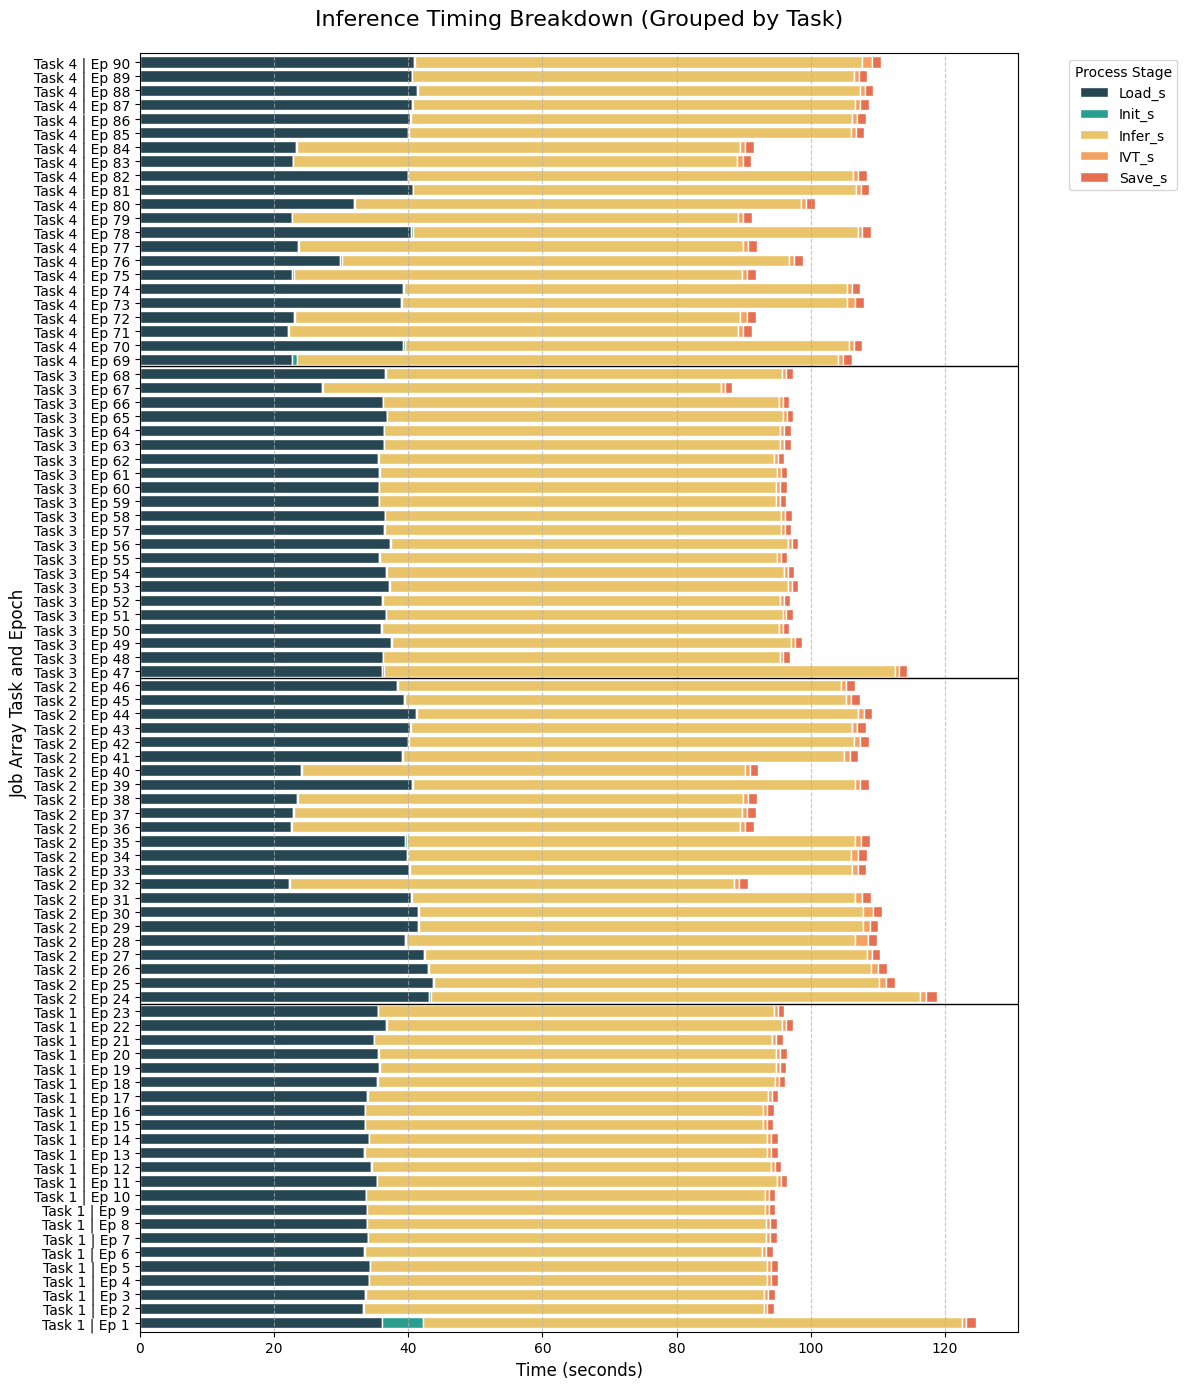

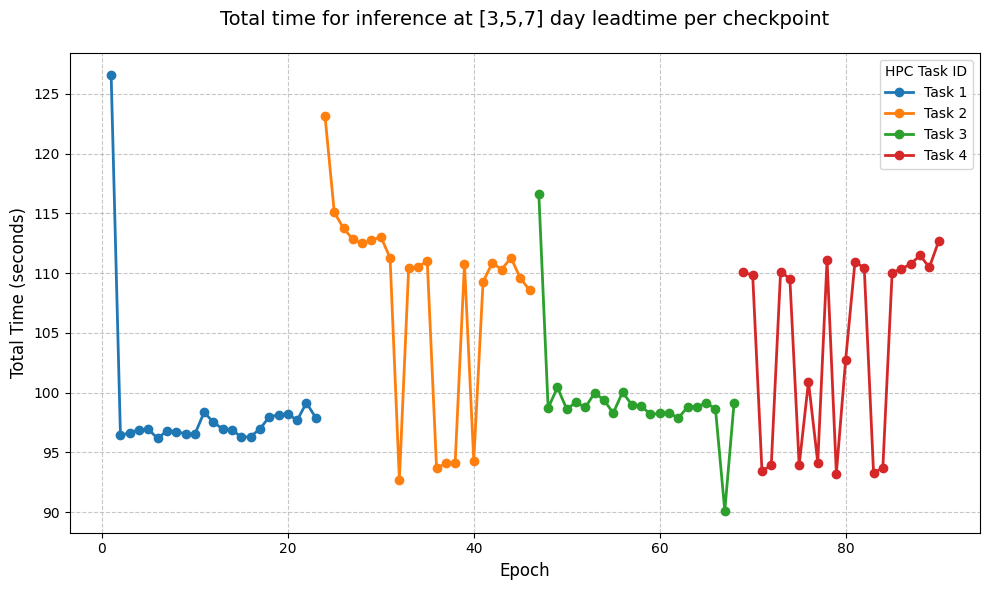

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 1. Load and aggregate the data with Task ID extraction
log_pattern = os.path.join('/projectnb/eb-general/wade/sfno/inference_runs', 'sandbox', 'Experiment4', '*', '*_performance_log_*.csv')
files = glob.glob(log_pattern)

all_dfs = []
for f in files:
    temp_df = pd.read_csv(f)
    # Extract Task ID from filename (e.g., ...task1.csv -> 1)
    # This splits by 'task', takes the last part, and removes the '.csv' extension
    task_id = f.split('task')[-1].split('.')[0]
    temp_df['Task'] = f"Task {task_id}"
    all_dfs.append(temp_df)

# Combine and sort so the epochs and tasks follow a logical sequence
df = pd.concat(all_dfs, ignore_index=True)
df = df.sort_values(['Task', 'Epoch'])

# Create a combined label for the Y-axis to show both Task and Epoch clearly
df['Display_Label'] = df['Task'] + " | Ep " + df['Epoch'].astype(str)

# 2. Define the stages to visualize
stages = ['Load_s', 'Init_s', 'Infer_s', 'IVT_s', 'Save_s']
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

# --- VISUALIZATION 1: Stacked Bar Chart with Task Grouping ---
fig, ax = plt.subplots(figsize=(12, 14)) # Taller figure to accommodate all tasks

df.set_index('Display_Label')[stages].plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=colors,
    edgecolor='white',
    width=0.8
)

ax.set_title('Inference Timing Breakdown (Grouped by Task)', fontsize=16, pad=20)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Job Array Task and Epoch', fontsize=12)
ax.legend(title="Process Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Optional: Add faint horizontal lines between tasks to visually separate them
current_task = None
for i, task in enumerate(df['Task']):
    if task != current_task and i > 0:
        ax.axhline(i - 0.5, color='black', linewidth=1, linestyle='-')
    current_task = task

plt.tight_layout()
# plt.savefig('timing_breakdown_by_task.png')

# --- VISUALIZATION 2: Total Time Comparison (Line Chart) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Plot one line per task to see if specific tasks/nodes are slower than others
for task in sorted(df['Task'].unique()):
    subset = df[df['Task'] == task]
    ax2.plot(subset['Epoch'], subset['Total_s'], marker='o', label=task, linewidth=2)

ax2.set_title('Total time for inference at [3,5,7] day leadtime per checkpoint', fontsize=14, pad=20)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Time (seconds)', fontsize=12)
ax2.legend(title="HPC Task ID")
ax2.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.savefig('total_time_comparison.png')

In [16]:
# find the average total_s time across all checkpoints in experiment 4
average_total_time = df['Total_s'].mean()
print(f'Average total_s time across all checkpoints in Experiment 4: {average_total_time:.2f} seconds')

Average total_s time across all checkpoints in Experiment 4: 102.59 seconds


In [30]:
# compute the total time for all 90 epochs in experiment 5
total_time_experiment = df['Total_s'].sum()
print(f'Total time for all 90 epochs: {total_time_experiment:.2f} seconds')
# convert to minutes
total_time_experiment_minutes = total_time_experiment / 60
print(f'Total time for all 90 epochs (adding together time from parallel tasks): {total_time_experiment_minutes:.2f} minutes')

Total time for all 90 epochs: 9233.49 seconds
Total time for all 90 epochs (adding together time from parallel tasks): 153.89 minutes


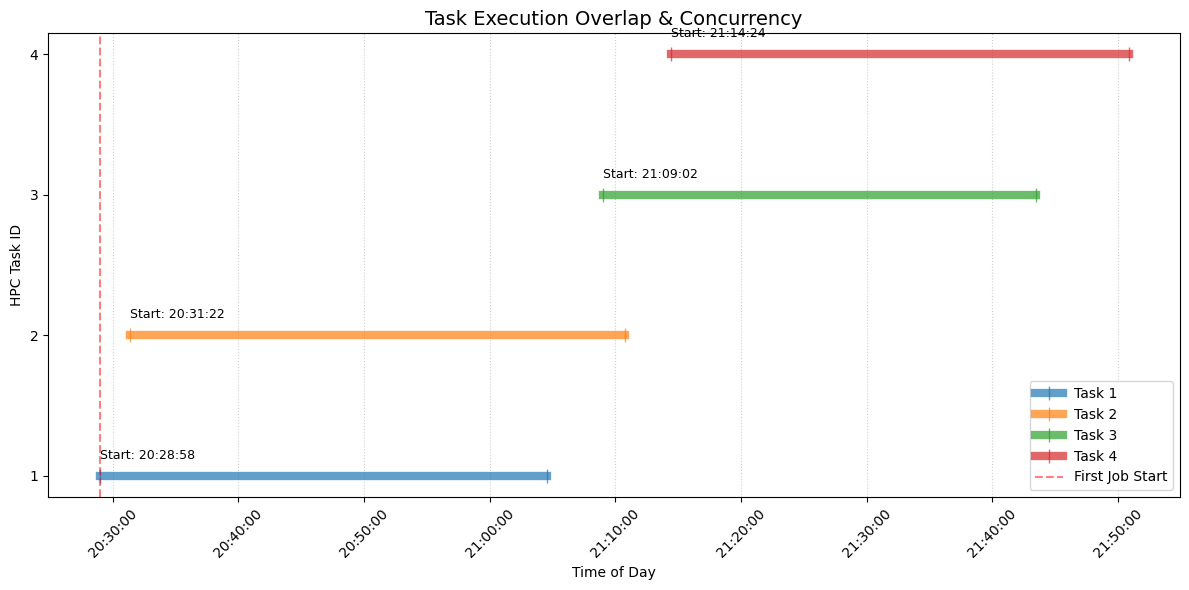

Execution Order (Who started first?):
Task
1   2026-01-30 20:28:58
2   2026-01-30 20:31:22
3   2026-01-30 21:09:02
4   2026-01-30 21:14:24
Name: Timestamp, dtype: datetime64[ns]


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import glob

# Load data (using your previous logic)
log_pattern = os.path.join('/projectnb/eb-general/wade/sfno/inference_runs', 'sandbox', 'Experiment4', '*', '*_performance_log_*.csv')
files = glob.glob(log_pattern)

all_dfs = []
for f in files:
    temp_df = pd.read_csv(f)
    task_id = f.split('task')[-1].split('.')[0]
    temp_df['Task'] = int(task_id) # Convert to int for proper sorting
    temp_df['Timestamp'] = pd.to_datetime(temp_df['Timestamp'])
    all_dfs.append(temp_df)

df = pd.concat(all_dfs, ignore_index=True).sort_values(['Task', 'Epoch'])

# --- TIMELINE VISUALIZATION ---
fig, ax = plt.subplots(figsize=(12, 6))

tasks = sorted(df['Task'].unique())
for i, task_id in enumerate(tasks):
    subset = df[df['Task'] == task_id].sort_values('Timestamp')
    
    start_time = subset['Timestamp'].min()
    end_time = subset['Timestamp'].max()
    
    # Plot horizontal line representing task duration
    ax.plot([start_time, end_time], [task_id, task_id], 
            marker='|', markersize=10, linewidth=6, alpha=0.7, label=f'Task {task_id}')
    
    # Annotate the start time of the first epoch
    ax.text(start_time, task_id + 0.1, f"Start: {start_time.strftime('%H:%M:%S')}", 
            fontsize=9, verticalalignment='bottom')

# Highlight the absolute first task that started
absolute_start = df['Timestamp'].min()
ax.axvline(absolute_start, color='red', linestyle='--', alpha=0.5, label='First Job Start')

ax.set_yticks(tasks)
ax.set_ylabel('HPC Task ID')
ax.set_xlabel('Time of Day')
ax.set_title('Task Execution Overlap & Concurrency', fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)
ax.grid(axis='x', linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- SUMMARY PRINT ---
first_starts = df.groupby('Task')['Timestamp'].min().sort_values()
print("Execution Order (Who started first?):")
print(first_starts)

In [ ]:
# compute the total time for all 90 epochs in experiment 5
total_time_experiment = df['Total_s'].sum()
print(f'Total time for all 90 epochs: {total_time_experiment:.2f} seconds')
# convert to minutes
total_time_experiment_minutes = total_time_experiment / 60
print(f'Total time for all 90 epochs (adding together time from parallel tasks): {total_time_experiment_minutes:.2f} minutes')

now, repeat for experiment 3


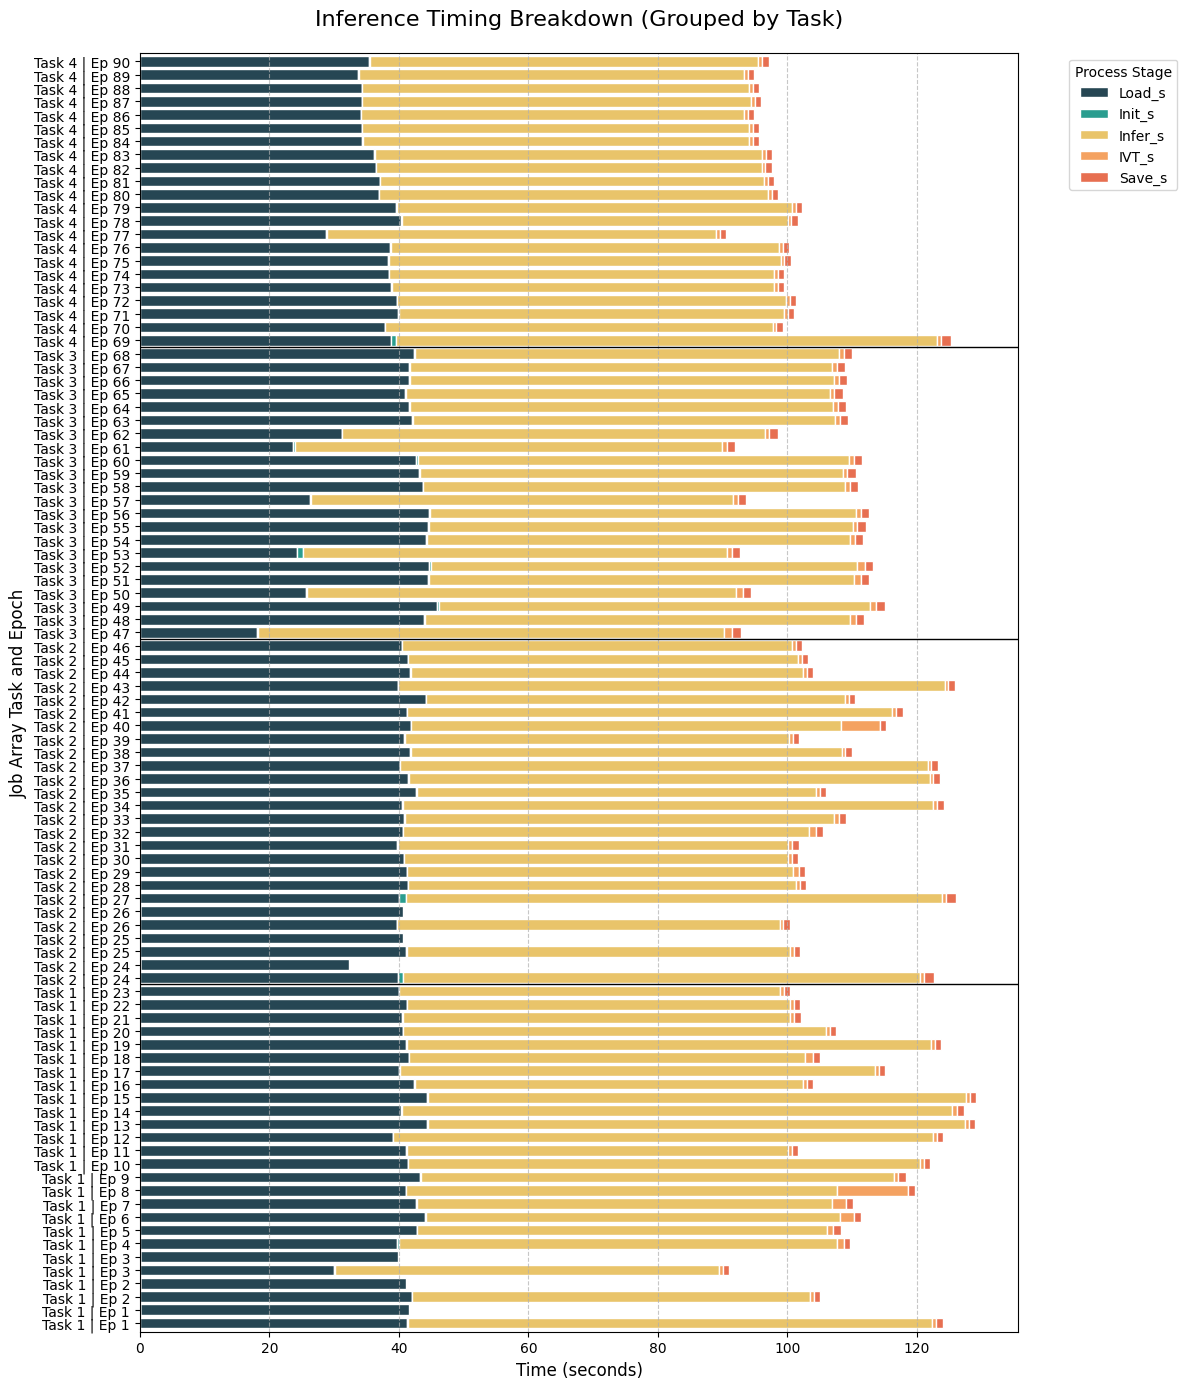

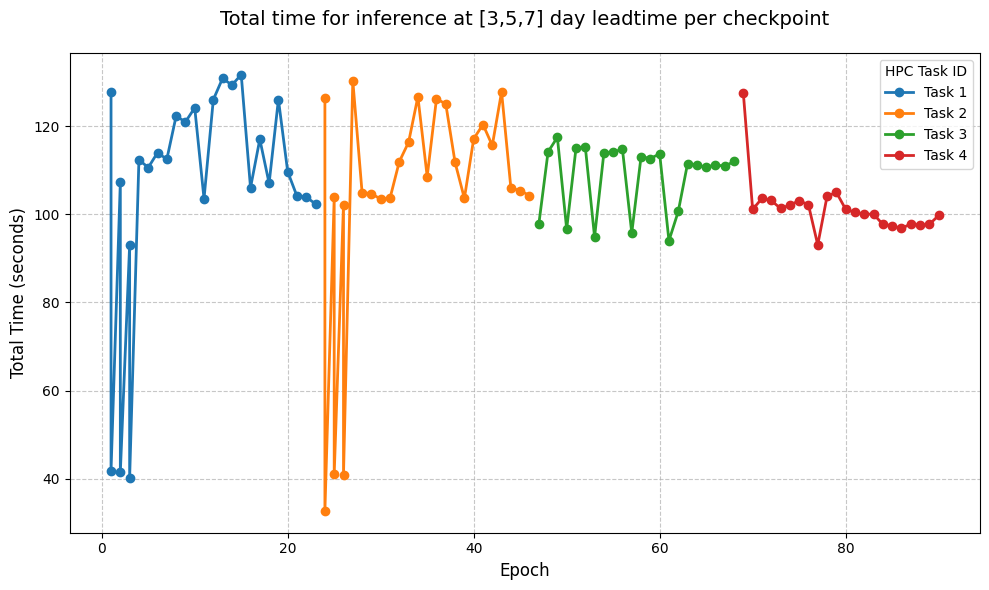

In [32]:
# 1. Load and aggregate the data with Task ID extraction
log_pattern = os.path.join('/projectnb/eb-general/wade/sfno/inference_runs', 'sandbox', 'Experiment3', '*', '*_performance_log_*.csv')
files = glob.glob(log_pattern)

all_dfs = []
for f in files:
    temp_df = pd.read_csv(f)
    # Extract Task ID from filename (e.g., ...task1.csv -> 1)
    # This splits by 'task', takes the last part, and removes the '.csv' extension
    task_id = f.split('task')[-1].split('.')[0]
    temp_df['Task'] = f"Task {task_id}"
    all_dfs.append(temp_df)

# Combine and sort so the epochs and tasks follow a logical sequence
df = pd.concat(all_dfs, ignore_index=True)
df = df.sort_values(['Task', 'Epoch'])

# Create a combined label for the Y-axis to show both Task and Epoch clearly
df['Display_Label'] = df['Task'] + " | Ep " + df['Epoch'].astype(str)

# 2. Define the stages to visualize
stages = ['Load_s', 'Init_s', 'Infer_s', 'IVT_s', 'Save_s']
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

# --- VISUALIZATION 1: Stacked Bar Chart with Task Grouping ---
fig, ax = plt.subplots(figsize=(12, 14)) # Taller figure to accommodate all tasks

df.set_index('Display_Label')[stages].plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=colors,
    edgecolor='white',
    width=0.8
)

ax.set_title('Inference Timing Breakdown (Grouped by Task)', fontsize=16, pad=20)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Job Array Task and Epoch', fontsize=12)
ax.legend(title="Process Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Optional: Add faint horizontal lines between tasks to visually separate them
current_task = None
for i, task in enumerate(df['Task']):
    if task != current_task and i > 0:
        ax.axhline(i - 0.5, color='black', linewidth=1, linestyle='-')
    current_task = task

plt.tight_layout()
# plt.savefig('timing_breakdown_by_task.png')

# --- VISUALIZATION 2: Total Time Comparison (Line Chart) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Plot one line per task to see if specific tasks/nodes are slower than others
for task in sorted(df['Task'].unique()):
    subset = df[df['Task'] == task]
    ax2.plot(subset['Epoch'], subset['Total_s'], marker='o', label=task, linewidth=2)

ax2.set_title('Total time for inference at [3,5,7] day leadtime per checkpoint', fontsize=14, pad=20)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Time (seconds)', fontsize=12)
ax2.legend(title="HPC Task ID")
ax2.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.savefig('total_time_comparison.png')

In [18]:
# GET THE AVERAGE TIME FOR EXP3
average_total_time = df['Total_s'].mean()
print(f'Average total_s time across all checkpoints in Experiment 3: {average_total_time:.2f} seconds')


Average total_s time across all checkpoints in Experiment 3: 105.31 seconds


In [33]:
# compute the total time for all 90 epochs in experiment 5
total_time_experiment = df['Total_s'].sum()
print(f'Total time for all 90 epochs: {total_time_experiment:.2f} seconds')
# convert to minutes
total_time_experiment_minutes = total_time_experiment / 60
print(f'Total time for all 90 epochs (adding together time from parallel tasks): {total_time_experiment_minutes:.2f} minutes')

Total time for all 90 epochs: 10109.32 seconds
Total time for all 90 epochs (adding together time from parallel tasks): 168.49 minutes


repeat for experimet 5

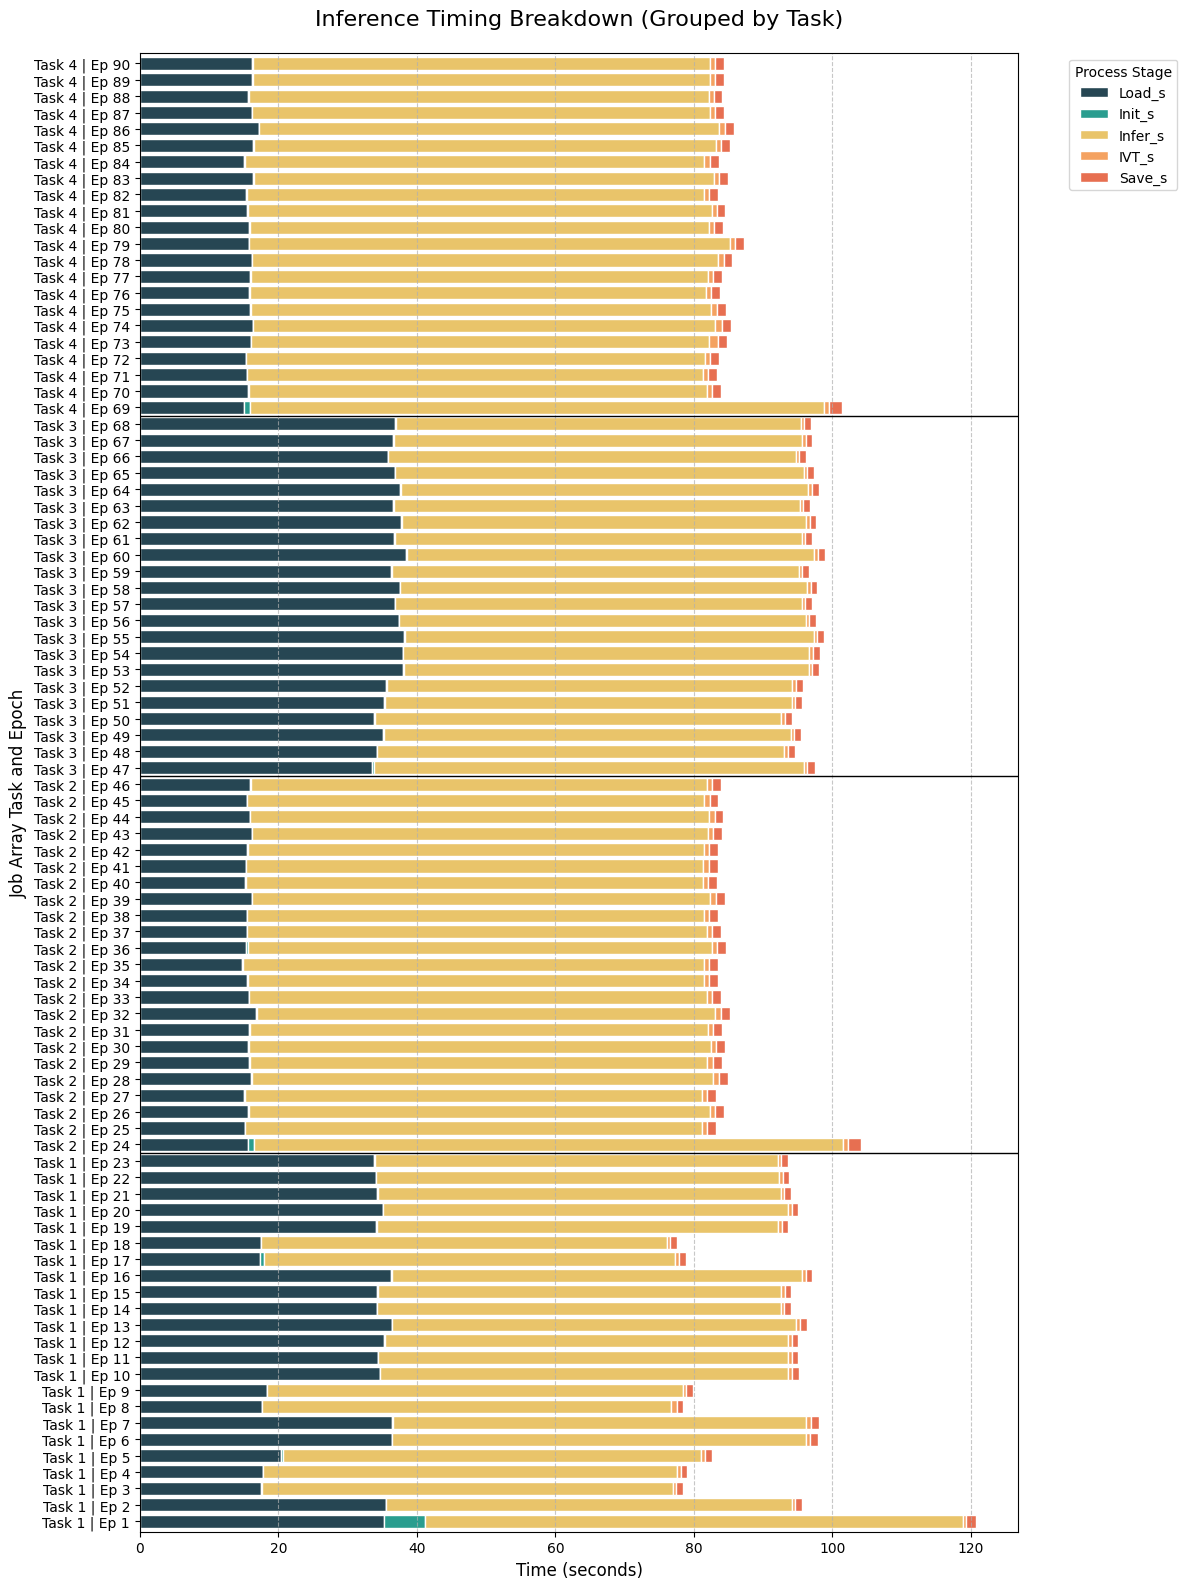

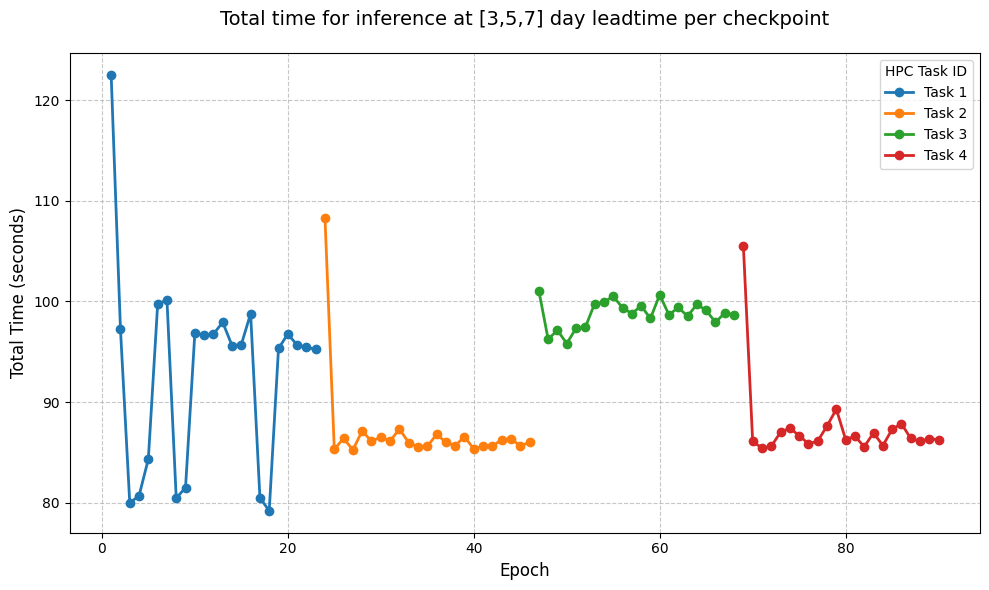

In [23]:
# 1. Load and aggregate the data with Task ID extraction
log_pattern = os.path.join('/projectnb/eb-general/wade/sfno/inference_runs', 'sandbox', 'Experiment5', '*', '*_performance_log_*.csv')
files = glob.glob(log_pattern)

all_dfs = []
for f in files:
    temp_df = pd.read_csv(f)
    # Extract Task ID from filename (e.g., ...task1.csv -> 1)
    # This splits by 'task', takes the last part, and removes the '.csv' extension
    task_id = f.split('task')[-1].split('.')[0]
    temp_df['Task'] = f"Task {task_id}"
    all_dfs.append(temp_df)

# Combine and sort so the epochs and tasks follow a logical sequence
df = pd.concat(all_dfs, ignore_index=True)
df = df.sort_values(['Task', 'Epoch'])

# Create a combined label for the Y-axis to show both Task and Epoch clearly
df['Display_Label'] = df['Task'] + " | Ep " + df['Epoch'].astype(str)

# 2. Define the stages to visualize
stages = ['Load_s', 'Init_s', 'Infer_s', 'IVT_s', 'Save_s']
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51']

# --- VISUALIZATION 1: Stacked Bar Chart with Task Grouping ---
fig, ax = plt.subplots(figsize=(12, 16)) # Taller figure to accommodate all tasks

df.set_index('Display_Label')[stages].plot(
    kind='barh', 
    stacked=True, 
    ax=ax, 
    color=colors,
    edgecolor='white',
    width=0.8
)

ax.set_title('Inference Timing Breakdown (Grouped by Task)', fontsize=16, pad=20)
ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Job Array Task and Epoch', fontsize=12)
ax.legend(title="Process Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Optional: Add faint horizontal lines between tasks to visually separate them
current_task = None
for i, task in enumerate(df['Task']):
    if task != current_task and i > 0:
        ax.axhline(i - 0.5, color='black', linewidth=1, linestyle='-')
    current_task = task

plt.tight_layout()
# plt.savefig('timing_breakdown_by_task.png')

# --- VISUALIZATION 2: Total Time Comparison (Line Chart) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Plot one line per task to see if specific tasks/nodes are slower than others
for task in sorted(df['Task'].unique()):
    subset = df[df['Task'] == task]
    ax2.plot(subset['Epoch'], subset['Total_s'], marker='o', label=task, linewidth=2)

ax2.set_title('Total time for inference at [3,5,7] day leadtime per checkpoint', fontsize=14, pad=20)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Total Time (seconds)', fontsize=12)
ax2.legend(title="HPC Task ID")
ax2.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.savefig('total_time_comparison.png')

In [24]:
# get average time for experiment 5
average_total_time = df['Total_s'].mean()
print(f'Average total_s time across all checkpoints in Experiment 5: {average_total_time:.2f} seconds')

Average total_s time across all checkpoints in Experiment 5: 91.57 seconds


In [28]:
# compute the total time for all 90 epochs in experiment 5
total_time_experiment = df['Total_s'].sum()
print(f'Total time for all 90 epochs: {total_time_experiment:.2f} seconds')
# convert to minutes
total_time_experiment_minutes = total_time_experiment / 60
print(f'Total time for all 90 epochs (adding together time from parallel tasks): {total_time_experiment_minutes:.2f} minutes')

Total time for all 90 epochs: 8241.46 seconds
Total time for all 90 epochs (adding together time from parallel tasks): 137.36 minutes
